In [44]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
import sklearn.preprocessing
from tqdm import tqdm

from src.mlhgp import MLHGP, HomGP
from src.imlhgp import IMLHGP
from src.nnpehgp import NNPEHGP
from src.kshgp import KSHGP
from src.ksmlhgp import KSMLHGP
from src.ksimlhgp import KSIMLHGP
from src.rnmlhgp import RNHGP as RNHGP2
from src.rnimlhgp import RNHGP as RNHGP3
from src import evaluator

## SUPPRESS ALL WARNINGS
import warnings
warnings.filterwarnings("ignore")

import scienceplots
import time

plt.style.use('science')

In [45]:
params = {'xtick.labelsize':12,
          'ytick.labelsize':12,
          'axes.labelsize': 16,
          'axes.titlesize': 18}
plt.rcParams.update(params)

# Problem Definition

In [46]:
def f1(X, add_noise=False):
    target = X * np.sin(X) + np.sqrt(16*X)
    if add_noise:
        rng = np.random.RandomState(1)
        target += rng.normal(0, 1, size=target.shape)
    return target.squeeze()

f2 = np.cos
transform = np.exp

## Try and compare one pass

### Training data

In [47]:
rng = np.random.RandomState(0)
X_train = rng.uniform(0, 10, size=25).reshape(-1, 1)
mean_train = f1(X_train, add_noise=False).reshape(-1,1)
scale_train = transform(f2(X_train))

np.random.seed(17)
y_train = np.random.normal(mean_train, scale_train)

### Testing Data

In [48]:
X_test = np.linspace(start=0, stop=10, num=1000).reshape(-1, 1)

# Compute loc and scale as functions of input X
mean_test = f1(X_test, add_noise=False).reshape(-1,1)
scale_test = transform(f2(X_test))

# Sample outputs Y from Gaussian Likelihood
y_test = np.random.normal(mean_test, scale_test)

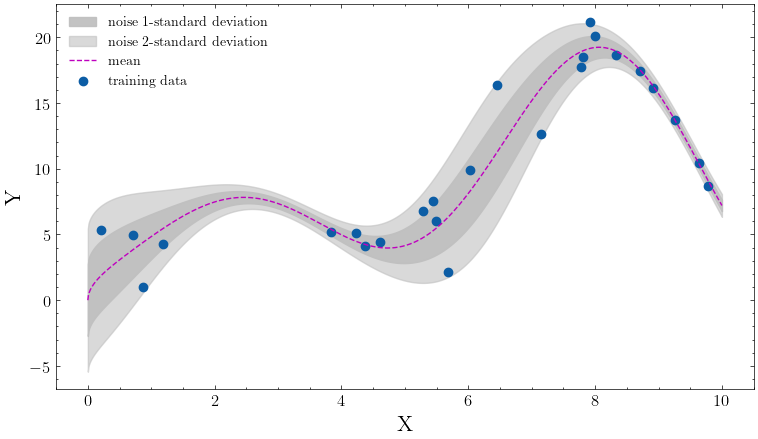

In [49]:
plt.figure(figsize=(9, 5))
x = X_test.squeeze()
for k in (1, 2):
    lb = (mean_test - k * scale_test).squeeze()
    ub = (mean_test + k * scale_test).squeeze()
    plt.fill_between(x, lb, ub, color="silver", alpha=1 - 0.05 * k ** 3, label=f"noise {k}-standard deviation")
plt.plot(X_test, mean_test, '--m', label="mean")
plt.scatter(X_train, y_train, label="training data")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig("img/case1_1d/original_function.pdf", dpi=300, format="pdf")
plt.show()

## Heteroscedastic vs Homoscedastic Illustration 

In [50]:
def f3(X):
    return 2*X + 3

In [51]:
np.random.seed(17)
## Hetero
x_hetero = np.linspace(start=0, stop=10, num=10000).reshape(-1, 1)

# Compute loc and scale as functions of input X
mean_hetero = f1(x_hetero, add_noise=False).reshape(-1,1)
scale_hetero = transform(f2(x_hetero))

# Sample outputs Y from Gaussian Likelihood
y_hetero = np.random.normal(mean_hetero, scale_hetero)

In [52]:
np.random.seed(17)
## Homogenous
x_homogen = np.linspace(start=0, stop=10, num=10000).reshape(-1, 1)

# Compute y homogenous
mean_homogen = f1(x_homogen, add_noise=False).reshape(-1,1)
y_homogen = np.random.normal(mean_homogen, 0.5)


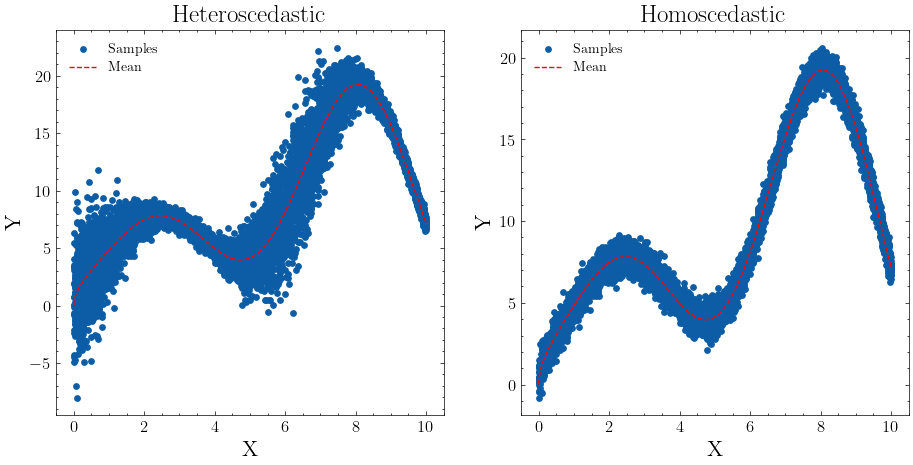

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
ax[0].scatter(x_hetero, y_hetero, s=15, label="Samples")
ax[0].plot(x_hetero, mean_hetero, "--r", label="Mean")
ax[0].set_title("Heteroscedastic")
ax[0].set_xlabel("X")
ax[0].set_ylabel("Y")
ax[1].scatter(x_homogen, y_homogen, s=15, label="Samples")
ax[1].plot(x_hetero, mean_hetero, "--r", label="Mean")
ax[1].set_title("Homoscedastic")
ax[1].set_xlabel("X")
ax[1].set_ylabel("Y")

ax[0].legend()
ax[1].legend()
plt.savefig("img/case1_1d/comparison.pdf", dpi=300, format="pdf")
plt.show()

### Normalize input feature

In [54]:
# Normalize X
normalizer = sklearn.preprocessing.StandardScaler().fit(X_train)
X_train_norm = X_train # normalizer.transform(X_train)
X_test_norm =  X_test # normalizer.transform(X_test)

### Define models

In [55]:
# define the model
def hgp_constructor(X_train_norm, y_train, kernel, kernel_noise):
    hgps = [MLHGP,IMLHGP,NNPEHGP,KSMLHGP,KSIMLHGP,HomGP]
    trained_hgps = []
    training_time = []

    for hgp in hgps:
        # Initialize models
        t1 = time.process_time()
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=25)
        gp_noise = GaussianProcessRegressor(kernel=kernel_noise, n_restarts_optimizer=25)
        model_hgp = hgp(model=gp, model_noise=gp_noise)

        # fit the model
        model_hgp.fit(X_train_norm, y_train.flatten())
        t2 = time.process_time()
        trained_hgps.append(model_hgp)
        training_time.append(t2-t1)

    return trained_hgps, training_time

In [56]:
kernel = ConstantKernel(1.0) * RBF(length_scale=1e-1, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(
        noise_level=1, noise_level_bounds=(1e-3, 1e1)
    )
kernel_noise = ConstantKernel(1.0) * RBF(length_scale=1e-1, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(
    noise_level=1, noise_level_bounds=(1e-3, 1e1)
)
hgp, training_time = hgp_constructor(X_train_norm, y_train, kernel, kernel_noise)

In [57]:
# make a prediction 
model_name = ["MLHGP", "IMLHGP", "NNPEHGP", "KSMLHGP", "KSIMLHGP", "GP"]
res_dict = {}
inf_time = []
for idx,hgp_model in enumerate(hgp):
    subres_dict = {}
    t1 = time.process_time()
    Y_pred, Std_pred = hgp_model.predict(X_test_norm, return_std="multi")
    t2 = time.process_time()
    subres_dict["y_pred"] = Y_pred
    subres_dict["std_pred"] = Std_pred
    res_dict[model_name[idx]] = subres_dict
    inf_time.append(t2-t1)

### Evaluation

#### Visual

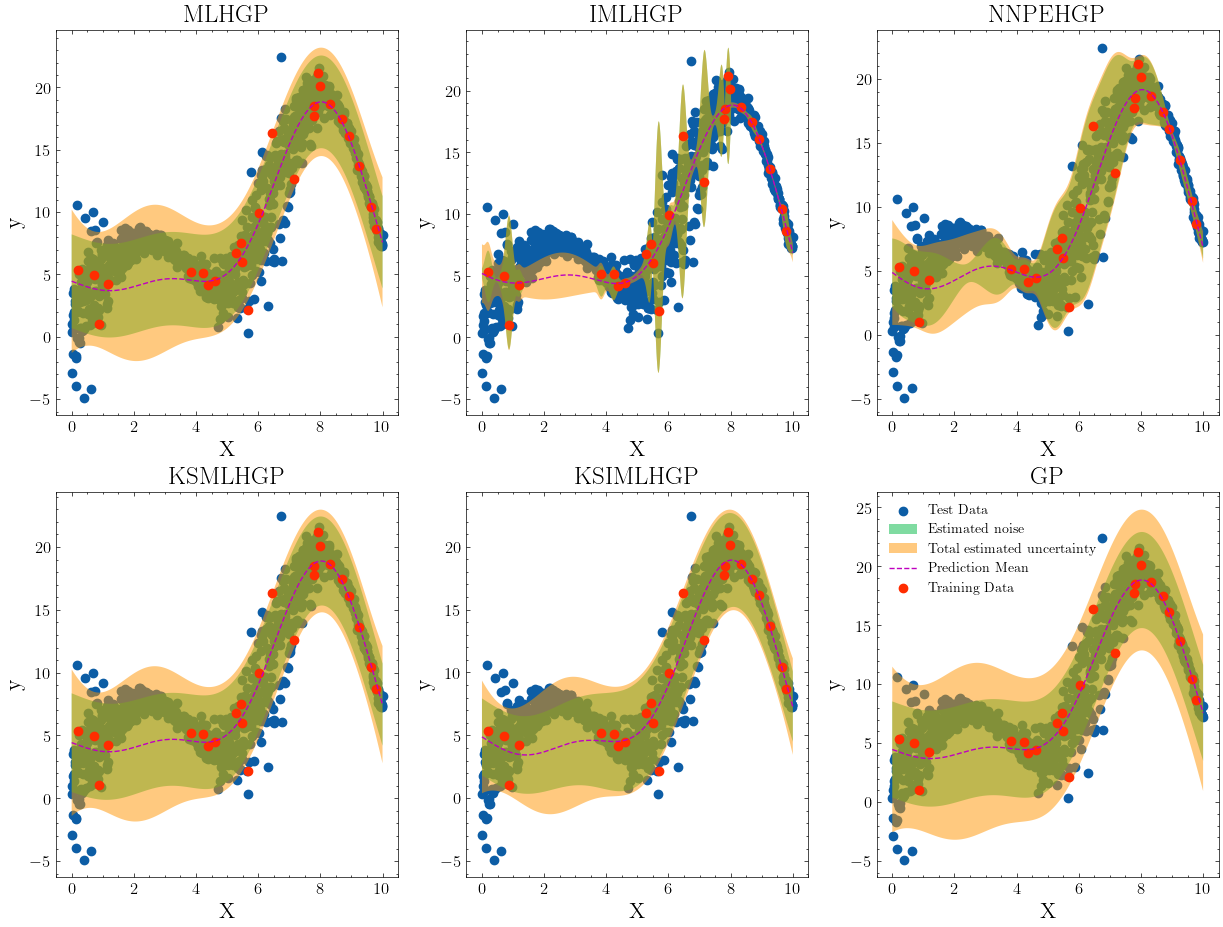

In [64]:
fig = plt.figure(figsize=(15,17))
spec = mpl.gridspec.GridSpec(ncols=6, nrows=3, wspace=0.5) # 6 columns evenly divides both 2 & 3

ax1 = fig.add_subplot(spec[0,0:2]) # row 0 with axes spanning 2 cols on evens
ax2 = fig.add_subplot(spec[0,2:4])
ax3 = fig.add_subplot(spec[0,4:])
ax4 = fig.add_subplot(spec[1,0:2]) # row 0 with axes spanning 2 cols on odds
ax5 = fig.add_subplot(spec[1,2:4])
ax6 = fig.add_subplot(spec[1,4:])

axs = [ax1,ax2,ax3,ax4,ax5,ax6]
idx = 0
for ax in axs:
    try:
        # Extract results
        name = model_name[idx]
        res = res_dict[name]
        y_pred = res["y_pred"]
        std_al, std_ep = res["std_pred"]
        std_tot = np.sqrt(std_al**2 + std_ep**2)

        ax.scatter(X_test,y_test, label="Test Data")
        x = X_test.squeeze()
        ax.fill_between(
            X_test.ravel(),
            y_pred - 1.96 * (std_al),
            y_pred + 1.96 * (std_al),
            alpha=0.5,
            label=r"Estimated noise",
        )
        ax.fill_between(
            X_test.ravel(),
            y_pred - 1.96 * std_tot,
            y_pred + 1.96 * std_tot,
            alpha=0.5,
            label=r"Total estimated uncertainty",
        )
        ax.plot(X_test, y_pred, "--m", label="Prediction Mean")
        ax.scatter(X_train, y_train, label="Training Data")
        ax.set_title(name)
        ax.set_xlabel("X")
        ax.set_ylabel("y")
        # ax.legend()
        idx += 1
    except:
        pass
    
plt.legend()
plt.savefig("img/case1_1d/one_realization.pdf", dpi=300, format="pdf")
plt.show()

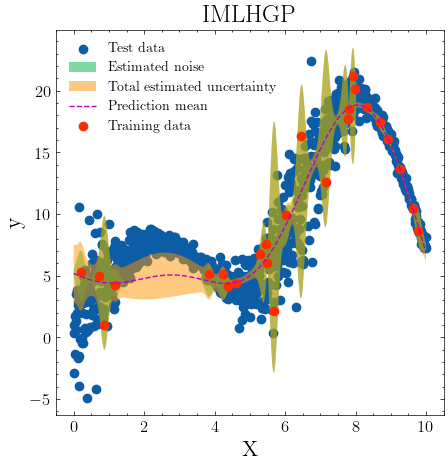

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
name = "IMLHGP"
res = res_dict[name]
y_pred = res["y_pred"]
std_al, std_ep = res["std_pred"]
std_tot = np.sqrt(std_al**2 + std_ep**2)

ax.scatter(X_test,y_test, label="Test data")
x = X_test.squeeze()
ax.fill_between(
    X_test.ravel(),
    y_pred - 1.96 * (std_al),
    y_pred + 1.96 * (std_al),
    alpha=0.5,
    label=r"Estimated noise",
)
ax.fill_between(
    X_test.ravel(),
    y_pred - 1.96 * std_tot,
    y_pred + 1.96 * std_tot,
    alpha=0.5,
    label=r"Total estimated uncertainty",
)
ax.plot(X_test, y_pred, "--m", label="Prediction mean")
ax.scatter(X_train, y_train, label="Training data")
ax.set_title(name)
ax.set_xlabel("X")
ax.set_ylabel("y")
ax.legend()
plt.savefig("img/case1_1d/imlhgp.pdf", dpi=300, format="pdf")
plt.show()


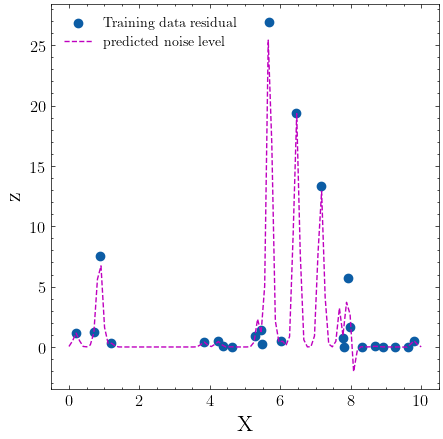

In [60]:
sorted = np.linspace(0,10,100).reshape(-1,1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
sorted_xtrain = np.sort(X_train, axis=0)
hetgp = hgp[1]
ax.scatter(X_train, (hetgp.z), label="Training data residual")
ax.plot(sorted, (hetgp.model_noise.predict(sorted)), "--m", label="predicted noise level")
ax.set_xlabel("X")
ax.set_ylabel("z")
plt.legend()
plt.savefig("img/case1_1d/imlhgp_residual.pdf", dpi=300, format="pdf")
plt.show()

In [18]:
for name,gp in zip(model_name,hgp):
    print(name)
    print(f"Kernel mean: {gp.model.kernel_}")
    try:
        print(f"Kernel noise: {gp.model_noise.kernel_}")
    except:
        pass

MLHGP
Kernel mean: 9.22**2 * RBF(length_scale=2.04) + WhiteKernel(noise_level=0.698)
Kernel noise: 1.26**2 * RBF(length_scale=100) + WhiteKernel(noise_level=0.267)
IMLHGP
Kernel mean: 9.91**2 * RBF(length_scale=2.26) + WhiteKernel(noise_level=0.001)
Kernel noise: 7.63**2 * RBF(length_scale=0.0787) + WhiteKernel(noise_level=0.001)
NNPEHGP
Kernel mean: 9.52**2 * RBF(length_scale=2.05) + WhiteKernel(noise_level=0.001)
Kernel noise: 3.87**2 * RBF(length_scale=0.474) + WhiteKernel(noise_level=0.00127)
KSMLHGP
Kernel mean: 9.26**2 * RBF(length_scale=2.04) + WhiteKernel(noise_level=0.523)
KSIMLHGP
Kernel mean: 9.28**2 * RBF(length_scale=2.03) + WhiteKernel(noise_level=0.001)
GP
Kernel mean: 9.22**2 * RBF(length_scale=2.04) + WhiteKernel(noise_level=4.33)


In [19]:
for ii in range(len(model_name)):
    print(model_name[ii])
    print(f"Training time = {training_time[ii]}  Inference time = {inf_time[ii]}")

MLHGP
Training time = 19.086754  Inference time = 0.0783699999999996
IMLHGP
Training time = 4.353468999999997  Inference time = 0.35439300000000173
NNPEHGP
Training time = 4.324017000000005  Inference time = 0.40704999999999814
KSMLHGP
Training time = 10.421141000000006  Inference time = 0.15681700000000376
KSIMLHGP
Training time = 2.311503000000002  Inference time = 0.37380699999999933
GP
Training time = 0.2169939999999997  Inference time = 0.197338000000002


#### Quantitative

In [20]:
def score_eval(X_test, y_test, y_test_mean, y_test_std, y_pred, std_al, std_ep):

    # Compute average Wasserstein distance (Earth moving distance)
    d_wass_list = []
    for i,x in enumerate(X_test):
        # actual distribution
        act_dist = [y_test_mean[i,:], y_test_std[i,:]]
        pred_dist = [y_pred[i], std_al[i]]

        d_wass, dists, m2 = evaluator.wasserstein2(act_dist, pred_dist)
        d_wass_list.append(d_wass)
    
    avg_wass = np.mean(d_wass_list)

    # Compute SMSE of noise
    smse = evaluator.noise_smse(std_al, y_test_std)

    # Compute NLPD
    std_tot = np.sqrt(std_al**2 + std_ep**2)
    nlpd = evaluator.nlpd_loss(y_test, y_pred, std_tot**2)

    return avg_wass, smse, nlpd

In [21]:
for name in model_name:
    res = res_dict[name]
    y_pred = res["y_pred"]
    std_al, std_ep = res["std_pred"]
    avg_wass, smse, nlpd = score_eval(X_test, y_test, mean_test, scale_test, y_pred, std_al, std_ep)
    print(name)
    print(f"Average Wasserstein: {avg_wass}, Noise SMSE: {smse}, NLPD: {nlpd}")

MLHGP
Average Wasserstein: 3.794880827071769, Noise SMSE: 1.6950196104377753, NLPD: 0.7977536999649812
IMLHGP
Average Wasserstein: 2.447881144218088, Noise SMSE: 1.6541166385862573, NLPD: 3.1093288929512592
NNPEHGP
Average Wasserstein: 2.325676917592557, Noise SMSE: 0.3939250780487293, NLPD: 0.8273356525590964
KSMLHGP
Average Wasserstein: 3.6368346881104463, Noise SMSE: 1.5386489538841792, NLPD: 0.8011840730014826
KSIMLHGP
Average Wasserstein: 4.0416091001387935, Noise SMSE: 1.4282830316466184, NLPD: 0.8295756853817668
GP
Average Wasserstein: 4.075370058172964, Noise SMSE: 2.0980946245811722, NLPD: 0.7231707905482138


In [22]:
scale_test

array([[2.71828183],
       [2.71814565],
       [2.71773716],
       [2.71705652],
       [2.71610401],
       [2.71488001],
       [2.71338501],
       [2.71161961],
       [2.7095845 ],
       [2.70728052],
       [2.70470856],
       [2.70186967],
       [2.69876497],
       [2.69539569],
       [2.69176317],
       [2.68786884],
       [2.68371426],
       [2.67930106],
       [2.67463098],
       [2.66970585],
       [2.66452761],
       [2.65909828],
       [2.65341998],
       [2.64749493],
       [2.64132541],
       [2.63491383],
       [2.62826265],
       [2.62137443],
       [2.61425181],
       [2.60689752],
       [2.59931436],
       [2.59150519],
       [2.58347297],
       [2.57522073],
       [2.56675155],
       [2.5580686 ],
       [2.5491751 ],
       [2.54007434],
       [2.53076968],
       [2.52126452],
       [2.51156232],
       [2.50166661],
       [2.49158095],
       [2.48130897],
       [2.47085433],
       [2.46022075],
       [2.44941197],
       [2.438

In [23]:
ale, epi = res_dict["KSMLHGP"]["std_pred"]
tot = np.sqrt(ale**2 + epi**2)

In [24]:
np.mean(np.log(2*np.pi*tot**2)) / 2

1.7817402969156624

In [25]:
np.mean(((mean_test - y_pred)**2 /(2*std_tot**2)))

707.9301589322096

In [26]:
np.min(scale_test)

0.36787988336599203

In [27]:
evaluator.nlpd_loss(mean_test, y_pred, std_tot**2)

1.67266525564526

## Varying random seeds

In [28]:
def train_data_maker(seednum, size=25):
    rng = np.random.RandomState(seednum)
    X_train = rng.uniform(0, 10, size=size).reshape(-1, 1)
    mean_train = f1(X_train, add_noise=False).reshape(-1,1)
    scale_train = transform(f2(X_train))

    np.random.seed(seednum)
    y_train = np.random.normal(mean_train, scale_train)

    return X_train, y_train

In [29]:
def main(datasize, repeat=100):

    model_name = ["ML", "IML", "NNPE", "KSML", "KSIML", "GP"]
    metrics_name = ["wasserstein", "smse", "nlpd", "model"]

    ## Initialize metrics and time dictionary
    model_scores = dict()
    for met in metrics_name:
        model_scores[met] = dict()
        for name in model_name:
            model_scores[met][name] = []
    
    model_scores["train_data"] = []

    time_data = dict()
    for name in model_name:
        time_data[name] = []

    for i in tqdm(range(repeat)):
        X_train, y_train = train_data_maker(seednum=i, size=datasize)
        train = {"x": X_train, "y": y_train}
        model_scores["train_data"].append(train)
        
        # Test data
        X_test = np.linspace(start=0, stop=10, num=1000).reshape(-1, 1)

        # Compute loc and scale as functions of input X
        mean_test = f1(X_test, add_noise=False).reshape(-1,1)
        scale_test = transform(f2(X_test))

        # Sample outputs Y from Gaussian Likelihood
        y_test = np.random.normal(mean_test, scale_test)
        
        # Normalize X
        normalizer = sklearn.preprocessing.StandardScaler().fit(X_train)
        X_train_norm = X_train # normalizer.transform(X_train)
        X_test_norm =  X_test # normalizer.transform(X_test)

        # Train models
        kernel = ConstantKernel(1.0) * RBF(length_scale=1e-1, length_scale_bounds=(1e-3, 1)) + WhiteKernel(
        noise_level=1, noise_level_bounds=(1e-3, 1e2)
        )
        kernel_noise = ConstantKernel(1.0) * RBF(length_scale=1e-1, length_scale_bounds=(1e-3, 1)) + WhiteKernel(
            noise_level=1, noise_level_bounds=(1e-3, 1e2)
        )
        hgp = hgp_constructor(X_train_norm, y_train, kernel, kernel_noise)

        # make a prediction 
        res_dict = {}
        hgp_models, hgp_time = hgp
        for nam,t_train in zip(model_name,hgp_time):
            time_data[nam].append(t_train)

        for idx,hgp_model in enumerate(hgp_models):
            subres_dict = {}
            Y_pred, Std_pred = hgp_model.predict(X_test_norm, return_std="multi")
            subres_dict["y_pred"] = Y_pred
            subres_dict["std_pred"] = Std_pred
            res_dict[model_name[idx]] = subres_dict
            model_scores["model"][model_name[idx]].append(hgp_model)
        
        # Evaluate
        for name in model_name:
            res = res_dict[name]
            y_pred = res["y_pred"]
            std_al, std_ep = res["std_pred"]
            avg_wass, smse, nlpd = score_eval(X_test, y_test, mean_test, scale_test, y_pred, std_al, std_ep)
            model_scores["wasserstein"][name].append(avg_wass)
            model_scores["smse"][name].append(smse)
            model_scores["nlpd"][name].append(nlpd)
        
    return model_scores,time_data

In [30]:
model_scores,time_data = main(datasize=25, repeat=50)

100%|██████████| 50/50 [10:44<00:00, 12.90s/it]


In [42]:
model_name = ["ML", "IML", "NNPE", "KSML", "KSIML", "GP"]
for nam in model_name:
    print(f"Training time for {nam}: {np.mean(time_data[nam])} " + "±" + f" {np.std(time_data[nam])} s")

Training time for ML: 16.20823889999999 ± 1.7917320664162533 s
Training time for IML: 3.66470227999999 ± 0.42559341512310095 s
Training time for NNPE: 3.625052340000011 ± 0.4204201472082647 s
Training time for KSML: 8.40324632000002 ± 0.8217702572453744 s
Training time for KSIML: 2.0824019199999997 ± 0.3063866236291554 s
Training time for GP: 0.4689721400000269 ± 0.234237545534374 s


In [32]:
params = {'xtick.labelsize':14,
          'ytick.labelsize':14,
          'axes.labelsize': 20,
          'axes.titlesize': 22}
plt.rcParams.update(params)

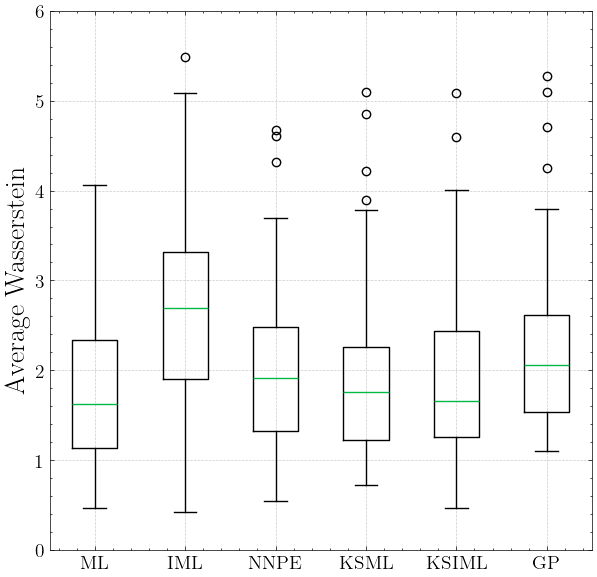

In [33]:
fig, ax = plt.subplots(figsize=(7,7))
ax.boxplot(model_scores["wasserstein"].values())
ax.set_xticklabels(model_scores["wasserstein"].keys())
ax.set_ylim((0,6))
ax.set_ylabel("Average Wasserstein")
plt.grid(True, color="0.8", linestyle='--')
plt.savefig("img/case1_1d/average_wasserstein.pdf", dpi=300, format="pdf")
plt.show()

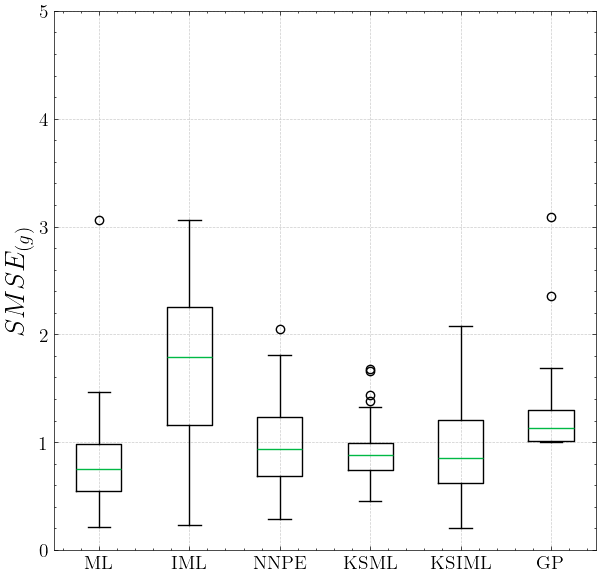

In [34]:
fig, ax = plt.subplots(figsize=(7,7))
ax.boxplot(model_scores["smse"].values())
ax.set_xticklabels(model_scores["wasserstein"].keys())
ax.set_ylim((0,5))
ax.set_ylabel(r"$SMSE_{(g)}$")
plt.grid(True, color="0.8", linestyle='--')
plt.savefig("img/case1_1d/smse.pdf", dpi=300, format="pdf")
plt.show()

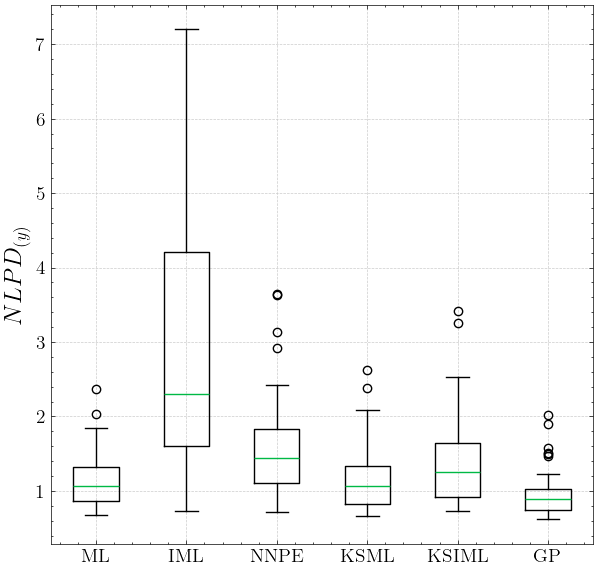

In [35]:
fig, ax = plt.subplots(figsize=(7,7))
ax.boxplot(model_scores["nlpd"].values())
ax.set_xticklabels(model_scores["wasserstein"].keys())
# ax.set_ylim((-70,250))
ax.set_ylabel(r"$NLPD_{(y)}$", fontsize=18)
plt.grid(True, color="0.8", linestyle='--')
plt.savefig("img/case1_1d/nlpd.pdf", dpi=300, format="pdf")
plt.show()

In [36]:
worst_nlpd_rnhgp = model_scores["model"]["KSML"][np.argmax(model_scores["nlpd"]["KSML"])]
data_worst_nlpd = model_scores["train_data"][np.argmax(model_scores["nlpd"]["KSML"])]

worst_wass_rnhgp = model_scores["model"]["KSML"][np.argmax(model_scores["wasserstein"]["KSML"])]
data_worst_wass = model_scores["train_data"][np.argmax(model_scores["wasserstein"]["KSML"])]

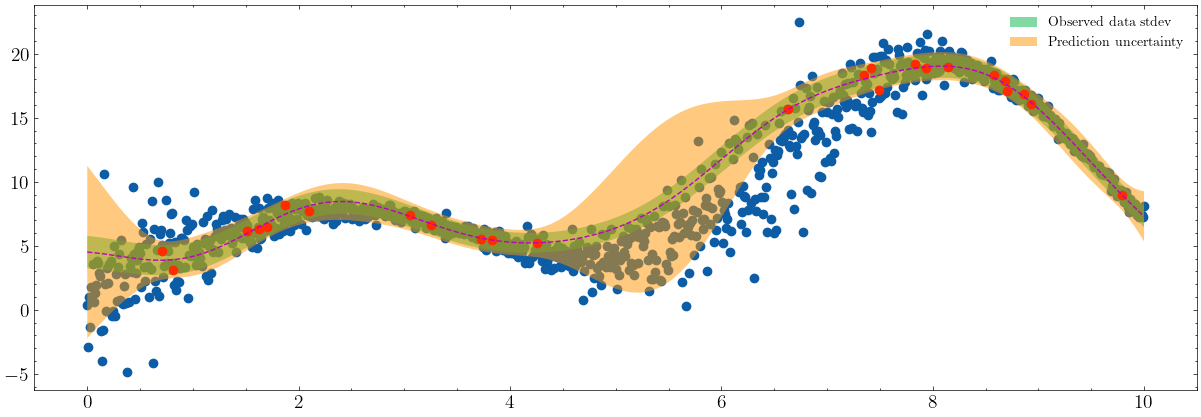

In [37]:
Y_pred, Std_pred = worst_nlpd_rnhgp.predict(X_test_norm, return_std="multi")
std_al, std_ep = Std_pred
std_tot = np.sqrt(std_al**2 + std_ep**2)

plt.figure(figsize=(15, 5))
plt.scatter(X_test,y_test)
x = X_test.squeeze()
plt.fill_between(
    X_test.ravel(),
    Y_pred - 1.96 * (std_al),
    Y_pred + 1.96 * (std_al),
    alpha=0.5,
    label=r"Observed data stdev",
)
plt.fill_between(
    X_test.ravel(),
    Y_pred - 1.96 * std_tot,
    Y_pred + 1.96 * std_tot,
    alpha=0.5,
    label=r"Prediction uncertainty",
)
plt.plot(X_test, Y_pred, "--m")
plt.scatter(data_worst_nlpd["x"], data_worst_nlpd["y"])
plt.legend()